In [1]:
from importlib import reload
import parkersolarwind as psw
import plot_parkersolarwind as plot_psw
import numpy as np
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt

### 1) Isothermal Parker Solar Wind

First, we solve and plot isothermal Parker solar wind solutions where the only free parameter is $T_0$, the coronal temperature, which is constant with radius out to infinity. This was the solution presented in the landmark Parker ([1958](https://ui.adsabs.harvard.edu/abs/1958ApJ...128..664P/abstract)) paper.

#### Code 

The solution is retrieved with the function :

`parkersolarwind.solve_parker_isothermal`(Rgrid, T0, [rho0], [r0]) $\rightarrow$ (Rgrid, rho_iso, u_iso, T_iso)

Where the inputs are: `Rgrid`[solar radii] is the radial grid spacing, `T0`[MK] is the isothermal temperature, `rho0`[kg/m^3] is the _mass_ density at the reference level and `r0`[solar radii] is the reference altitude itself. The last two are keywords and don't need to be supplied explicitly.

The outputs are: `Rgrid`[solar radii], `rho_iso`[kg cm^-3] is the density at all grid points, `u_iso`[km/s] is the velocity at all grid points and T_iso[MK] is the temperature at all grid points (which of course is just a horizontal line). 

All inputs and outputs are `astropy.units.Quantity` and so could be provided in different units as desired (e.g. km/s -> cm/hour etc...)

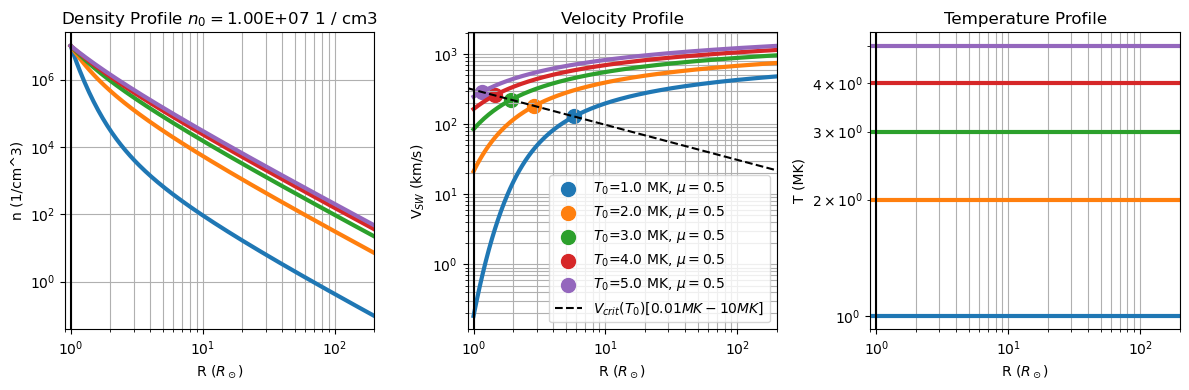

In [2]:
Rgrid = np.logspace(0,np.log10(200),200)*u.R_sun
T0_arr = np.linspace(1,5,5)*u.MK
iso_sols = [psw.solve_parker_isothermal(Rgrid,T0) for T0 in T0_arr]
fig,axes=plot_psw.plot_isothermal(iso_sols,lw=3)

### 2) Solve and plot a pure polytropic solar wind

Next, we solve for transonic solar wind solutions for the case of a polytropic fluid with $\frac{d}{dr}(p\rho^\gamma) = \frac{d}{dr} (T\rho^{\gamma-1}) = 0$, and a temperature at the coronal base $T_0$. 

This is a two step process following Shi+([2022](https://ui.adsabs.harvard.edu/abs/2022arXiv220903508S/abstract)) III.B. In the first step, the critical point (radius and velocity) is numerically solved for. In the second step, we solve Bernouilli's equation for a spherically symmetric hydrodynamic steady flow with polytropic index $\gamma$ subject to the boundary condition that forces the solution to intersect with the critical point, _and_ be monotonically increasing. 

Below we plot solutions for a range of adiabatic indices for a fixed coronal temperature.

Note that for a given $T_0$ there is a max adiabatic index $\gamma_c$ at which the critical radius $r_c \rightarrow \infty$ and therefore transonic solutions don't exist. 

In the example below, we go up to $\gamma=1.4$ at $T_0=4MK$ which is close to the critical limit, and the max $\gamma$ which gives solutions at _any_ temperature. 

The combinations of $\gamma$ and $T_0$ do not give realistic solutions for solar wind measurements: To get $\gamma$ large enough to explain observations of the drop off in plasma temperature with distance, $T_0$ needs to be unrealistically high.

#### Code

The solution is retrieved with the function :

`parkersolarwind.solve_parker_polytropic`(Rgrid, T0, gamma, [rho0], [r0], [u0]) $\rightarrow$ (Rgrid, rho_poly, u_poly, T_poly, r_crit, uc_crit)

Where the inputs are: `Rgrid`[solar radii] is the radial grid spacing, `T0`[MK] is the temperature at the inner boundary, `rho0`[kg/cm^3] is the _mass_ density at the reference level, `r0`[solar radii] is the reference altitude. `u0`[solar radii], which defaults to `None`, can be used to provide an arbitrary flow speed at the inner boundary, bypassing the critical point solution part. If it is used then the solution will not be guaranteed to be transonic. This is however useful when combining the polytropic solution with an isothermal layer (see next section). 

The outputs are: `Rgrid`[solar radii], `rho_poly`[kg/cm^3] is the density at all grid points, `u_poly`[km/s] is the velocity at all grid points and `T_poly`[MK] is the temperature at all grid points. (`r_crit`[solar radii],`uc_crit`[km/s]) are the radius and sound speed at the critical point for a transonic solution.

All inputs (except for `type(gamma)==float`) and all outputs are `astropy.units.Quantity` and so could be provided in different units as desired (e.g. km/s -> cm/hour etc...). Note the plotting routine defined here also needs to know `T0` and `gamma`, and they must be appended as a tuple to the output of `solve_parker_polytropic`.

/home/sbadman/1_RESEARCH/GIT_REPOS/ParkerSolarWind/parkersolarwind.py:88: RuntimeWarning: invalid value encountered in power
  term2 = uc0_**2/(gamma_-1) * (((u0_*r0_**2)/(u_*r_**2))**(gamma_-1) - 1)


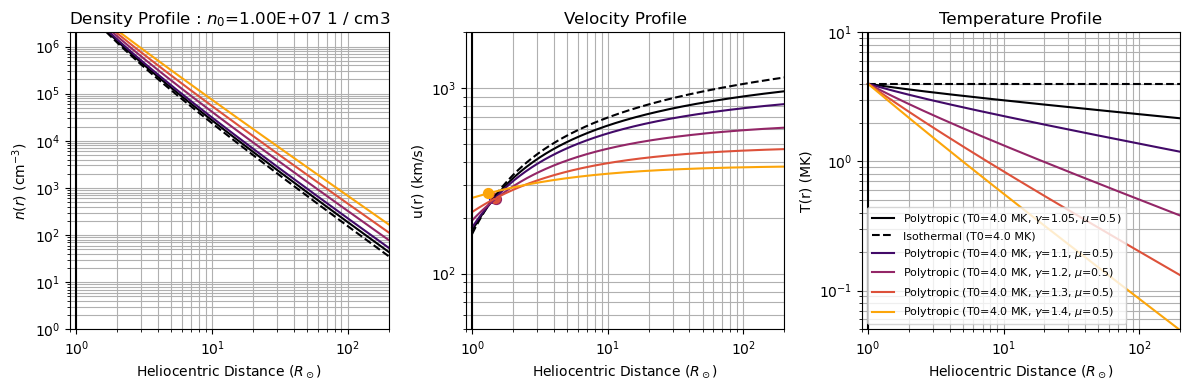

In [3]:
T0 = 4*u.MK
gammas = [1.05,1.1,1.2,1.3,1.4]
mu=0.5
Rgrid = np.logspace(0,np.log10(200),200)*u.R_sun
sols = [psw.solve_parker_polytropic(Rgrid, T0, gamma)
        for gamma in gammas
       ]
fig,axes=plot_psw.plot_polytropic(
    sols,[True,False,False,False,False]
)

### 3) Solve and plot an isothermal layer model

In this example, the solar wind is assumed to be isothermal from $1R_\odot$ out to some radius $R_{iso}$, approximating temperature behavior in the corona. 

Beyond this radius the solar wind is assumed to be polytropic with index $\gamma$. 

As long as (1) the solar wind goes supersonic inside the isothermal layer and (2) the solar wind remains supersonic across the discontinuity in sound speed at the isothermal-polytropic boundary, then accelerating solutions are found for $r \rightarrow \infty$ 

#### Code

The solution is retrieved with the function :

`parkersolarwind.solve_isothermal_layer`(Rgrid, R_iso, T_iso, gamma, [rho0]) $\rightarrow$ (R_iso, rho_iso, u_iso, T_iso, R_poly, rho_poly, u_poly, T_poly)

Where the inputs are: `Rgrid`[solar radii] is the radial grid spacing, `R_iso`[solar radii] is the radius of the outer boundary of the isothermal layer, `T0`[MK] is the temperature at the inner boundary, `gamma` is the polytropic index for the polytropic layer, `rho0`[kg/cm^3] is the _mass_ density at the reference level.

The outputs are: `R_[iso/poly]`[solar radii], `rho_[iso/poly]`[kg/cm^3] is the density at all grid points, `u_[iso/poly]`[km/s] is the velocity at all grid points and `T_[iso/poly]`[MK] is the temperature at all grid points where `iso` or `poly` indicate whether the quantity is for the isothermal or polytropic layer respectively.

All inputs (except for `type(gamma)==float`) and all outputs are `astropy.units.Quantity` and so could be provided in different units as desired (e.g. km/s -> cm/hour etc...).

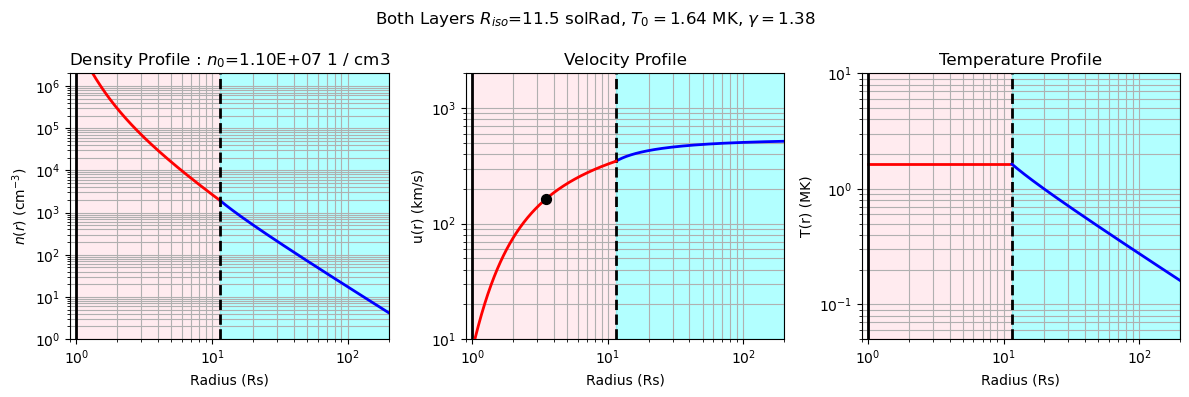

In [4]:
sol = psw.solve_isothermal_layer(
    np.logspace(0,np.log10(200),400)*u.R_sun, # Radial grid points
    11.5*u.R_sun, # Isothermal layer outer radius
    1.64*u.MK, # Isothermal layer temperature
    1.38, # Polytropic layer polytropic index
    n0=11e6/u.cm**3 # Density normalization
) 
fig,axes=plot_psw.plot_isothermal_layer(sol)